In [1]:
!pip3 install graphviz
!pip3 install dask
!pip install "dask[complete]"
!pip3 install toolz
!pip3 install cloudpickle
!pip3 install folium
!pip install gpxpy
!pip3 install pyroomacoustics


import os
import time
import math
import scipy
import pickle
import warnings
import datetime
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import xgboost as xgb
import matplotlib.pylab as plt

import folium

import dask.dataframe as dd

import gpxpy.geo

from matplotlib import rcParams

from pyroomacoustics.doa.detect_peaks import detect_peaks

from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression

from prettytable import PrettyTable
from datetime import datetime as dt

matplotlib.use('nbagg');
warnings.filterwarnings("ignore");
%matplotlib inline



INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.1/35.1 MB 23.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for pyroomacoustics: filename=pyroomacoustics-0.8.3-cp311-cp311-linux_x86_64.whl size=46837492 sha256=98f462a3

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_jan = dd.read_csv('/content/drive/MyDrive/Colab Datasets/yellow_tripdata_2015-01.csv')

In [4]:
df_jan.shape

(<dask_expr.expr.Scalar: expr=ReadCSV(0846755).size() // 19, dtype=int64>, 19)

In [5]:
df_jan.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,40.759109,1,14.5,0.5,0.5,2.00,0.0,0.3,17.80
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,40.824413,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,40.719986,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,40.742653,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30


### Pickup Latitude and Pickup Longitude

In [6]:
# Plotting pickup cordinates which are outside the bounding box of New-York
# we will collect all the points outside the bounding box of newyork city to outlier_locations

outlier_locations = df_jan[((df_jan.pickup_longitude <= -74.15) | (df_jan.pickup_latitude <= 40.5774)| \
                   (df_jan.pickup_longitude >= -73.7004) | (df_jan.pickup_latitude >= 40.9176))]
print("Number of Outlier Locations:", len(outlier_locations))

map_osm = folium.Map(location=[40.734695, -73.990372],
                    tiles='Stamen Toner',
                    attr='Stamen')
sample_locations = outlier_locations.head(10000)
for i,j in sample_locations.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['pickup_latitude'],j['pickup_longitude']))).add_to(map_osm)


map_osm

Number of Outlier Locations: 247742


### Dropoff Latitude & Dropoff Longitude

In [7]:
# Plotting dropoff cordinates which are outside the bounding box of New-York
# we will collect all the points outside the bounding box of newyork city to outlier_locations

outlier_locations = df_jan[((df_jan.dropoff_longitude <= -74.15) | (df_jan.dropoff_latitude <= 40.5774)| \
                   (df_jan.dropoff_longitude >= -73.7004) | (df_jan.dropoff_latitude >= 40.9176))]
print("Number of Outlier Locations:", len(outlier_locations))

map_osm = folium.Map(location=[40.734695, -73.990372],
                    tiles='Stamen Toner',
                    attr='Stamen')
sample_locations = outlier_locations.head(10000)
for i,j in sample_locations.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['dropoff_latitude'],j['dropoff_longitude']))).add_to(map_osm)


map_osm

Number of Outlier Locations: 264440


### Trip Duration

In [8]:
def convert_to_unix(s):
    return time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple())

def return_with_trip_times(df_jan):
    duration = df_jan[['tpep_pickup_datetime','tpep_dropoff_datetime']].compute()
    #pickups and dropoffs to unix time
    duration_pickup = [convert_to_unix(x) for x in duration['tpep_pickup_datetime'].values]
    duration_drop = [convert_to_unix(x) for x in duration['tpep_dropoff_datetime'].values]
    #calculate duration of trips
    durations = (np.array(duration_drop) - np.array(duration_pickup))/float(60)

    #append durations of trips and speed in miles/hr to a new dataframe
    new_frame = df_jan[['passenger_count','trip_distance','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','total_amount']].compute()

    new_frame['trip_times'] = durations
    new_frame['pickup_times'] = duration_pickup
    new_frame['Speed'] = 60*(new_frame['trip_distance']/new_frame['trip_times'])

    return new_frame

frame_with_durations = return_with_trip_times(df_jan)

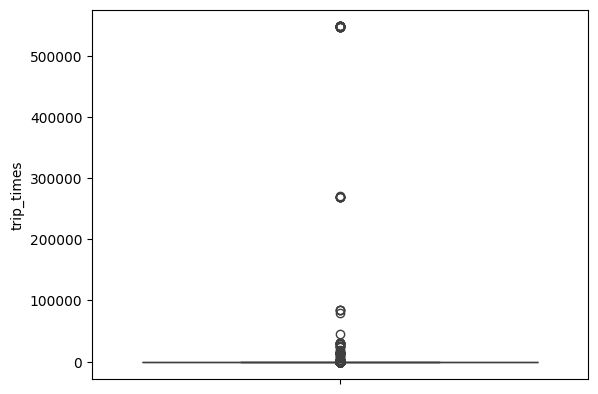

In [9]:
# the skewed box plot shows us the presence of outliers
sns.boxplot(y="trip_times", data = frame_with_durations)
plt.show()

In [10]:
#calculating 0-100th percentile to find a the correct percentile value for removal of outliers
for i in range(0,100,10):
    var = frame_with_durations["trip_times"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is -1211.0166666666667
10 percentile value is 3.8333333333333335
20 percentile value is 5.383333333333334
30 percentile value is 6.816666666666666
40 percentile value is 8.3
50 percentile value is 9.95
60 percentile value is 11.866666666666667
70 percentile value is 14.283333333333333
80 percentile value is 17.633333333333333
90 percentile value is 23.45
100 percentile value is  548555.6333333333


In [11]:
#looking further from the 99th percecntile
for i in range(90,100):
    var =frame_with_durations["trip_times"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

90 percentile value is 23.45
91 percentile value is 24.35
92 percentile value is 25.383333333333333
93 percentile value is 26.55
94 percentile value is 27.933333333333334
95 percentile value is 29.583333333333332
96 percentile value is 31.683333333333334
97 percentile value is 34.46666666666667
98 percentile value is 38.71666666666667
99 percentile value is 46.75
100 percentile value is  548555.6333333333


In [12]:
#removing data based on our analysis and TLC regulations
frame_with_durations_modified=frame_with_durations[(frame_with_durations.trip_times>1) & (frame_with_durations.trip_times<720)]

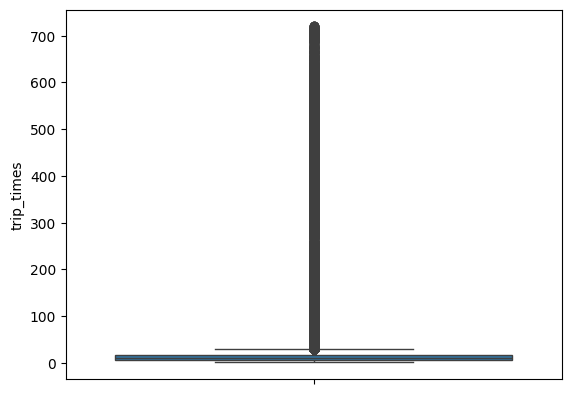

In [13]:
#box-plot after removal of outliers
sns.boxplot(y="trip_times", data =frame_with_durations_modified)
plt.show()

### Speed

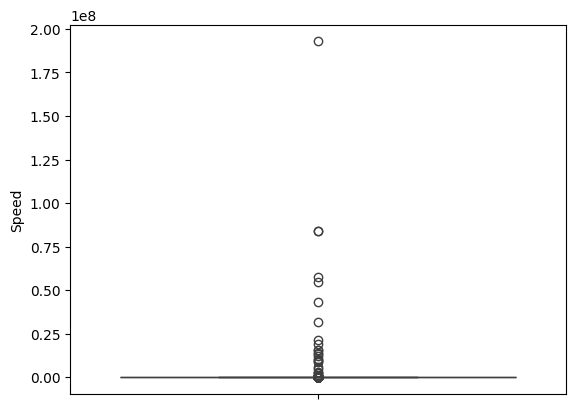

In [14]:
# check for any outliers in the data after trip duration outliers removed
# box-plot for speeds with outliers
frame_with_durations_modified['Speed'] = 60*(frame_with_durations_modified['trip_distance']/frame_with_durations_modified['trip_times'])
sns.boxplot(y="Speed", data =frame_with_durations_modified)
plt.show()

In [15]:
#calculating speed values at each percntile 0,10,20,30,40,50,60,70,80,90,100
for i in range(0,100,10):
    var =frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 0.0
10 percentile value is 6.409495548961425
20 percentile value is 7.80952380952381
30 percentile value is 8.929133858267717
40 percentile value is 9.98019801980198
50 percentile value is 11.06865671641791
60 percentile value is 12.286689419795222
70 percentile value is 13.796407185628745
80 percentile value is 15.963224893917962
90 percentile value is 20.186915887850468
100 percentile value is  192857142.85714284


In [16]:
#calculating speed values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var =frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 20.186915887850468
91 percentile value is 20.91645569620253
92 percentile value is 21.752988047808763
93 percentile value is 22.721893491124263
94 percentile value is 23.844155844155843
95 percentile value is 25.182552504038775
96 percentile value is 26.80851063829787
97 percentile value is 28.84304932735426
98 percentile value is 31.591128254580514
99 percentile value is 35.7513566847558
100 percentile value is  192857142.85714284


In [17]:
#calculating speed values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var =frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 35.7513566847558
99.1 percentile value is 36.31084727468969
99.2 percentile value is 36.91470054446461
99.3 percentile value is 37.588235294117645
99.4 percentile value is 38.33035714285714
99.5 percentile value is 39.17580340264651
99.6 percentile value is 40.15384615384615
99.7 percentile value is 41.338301043219076
99.8 percentile value is 42.86631016042781
99.9 percentile value is 45.3107822410148
100 percentile value is  192857142.85714284


In [20]:
#removing further outliers based on the 99.9th percentile value
frame_with_durations_modified=frame_with_durations[(frame_with_durations.Speed>0) & (frame_with_durations.Speed<45.31)]

In [21]:
#avg.speed of cabs in New-York
sum(frame_with_durations_modified["Speed"]) / float(len(frame_with_durations_modified["Speed"]))

12.450173996027528

### Trip Distance

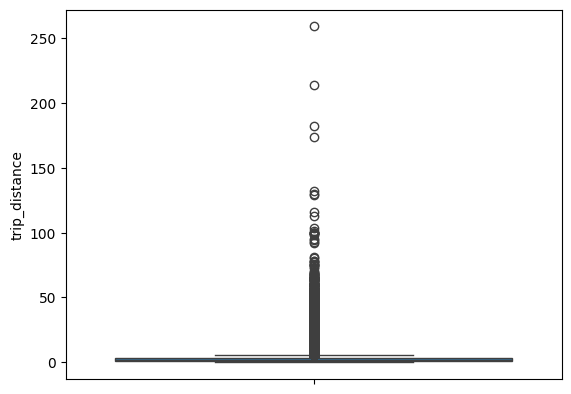

In [22]:
# up to now we have removed the outliers based on trip durations and cab speeds
# lets try if there are any outliers in trip distances
# box-plot showing outliers in trip-distance values
sns.boxplot(y="trip_distance", data =frame_with_durations_modified)
plt.show()

In [23]:
#calculating trip distance values at each percntile 0,10,20,30,40,50,60,70,80,90,100
for i in range(0,100,10):
    var =frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 0.01
10 percentile value is 0.66
20 percentile value is 0.9
30 percentile value is 1.1
40 percentile value is 1.39
50 percentile value is 1.69
60 percentile value is 2.07
70 percentile value is 2.6
80 percentile value is 3.6
90 percentile value is 5.97
100 percentile value is  258.9


In [24]:
#calculating trip distance values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var =frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 5.97
91 percentile value is 6.45
92 percentile value is 7.07
93 percentile value is 7.85
94 percentile value is 8.72
95 percentile value is 9.6
96 percentile value is 10.6
97 percentile value is 12.1
98 percentile value is 16.03
99 percentile value is 18.17
100 percentile value is  258.9


In [25]:
#calculating trip distance values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var =frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 18.17
99.1 percentile value is 18.37
99.2 percentile value is 18.6
99.3 percentile value is 18.83
99.4 percentile value is 19.13
99.5 percentile value is 19.5
99.6 percentile value is 19.96
99.7 percentile value is 20.5
99.8 percentile value is 21.22
99.9 percentile value is 22.57
100 percentile value is  258.9


In [27]:
#removing further outliers based on the 99.9th percentile value
frame_with_durations_modified=frame_with_durations[(frame_with_durations.trip_distance>0) & (frame_with_durations.trip_distance<23)]

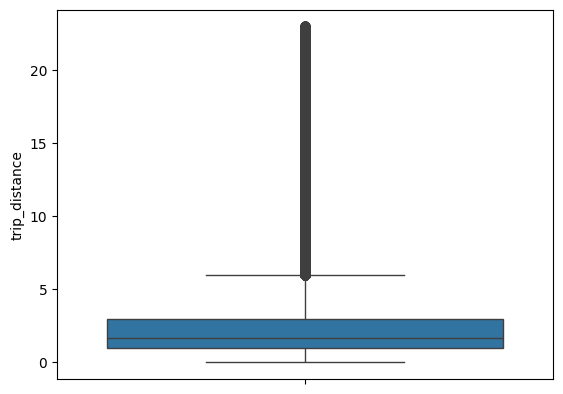

In [28]:
#box-plot after removal of outliers
sns.boxplot(y="trip_distance", data = frame_with_durations_modified)
plt.show()

### Total Fare

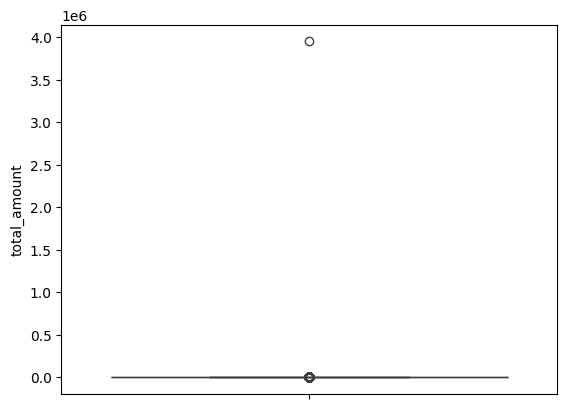

In [29]:
# up to now we have removed the outliers based on trip durations, cab speeds, and trip distances
# lets try if there are any outliers in based on the total_amount
# box-plot showing outliers in fare
sns.boxplot(y="total_amount", data =frame_with_durations_modified)
plt.show()

In [30]:
#calculating total fare amount values at each percntile 0,10,20,30,40,50,60,70,80,90,100
for i in range(0,100,10):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is -242.55
10 percentile value is 6.3
20 percentile value is 7.8
30 percentile value is 8.8
40 percentile value is 9.8
50 percentile value is 11.16
60 percentile value is 12.8
70 percentile value is 14.8
80 percentile value is 18.3
90 percentile value is 25.8
100 percentile value is  3950611.6


In [31]:
#calculating total fare amount values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 25.8
91 percentile value is 27.3
92 percentile value is 29.3
93 percentile value is 31.8
94 percentile value is 34.8
95 percentile value is 38.53
96 percentile value is 42.6
97 percentile value is 48.13
98 percentile value is 58.13
99 percentile value is 66.13
100 percentile value is  3950611.6


In [32]:
#calculating total fare amount values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 66.13
99.1 percentile value is 68.13
99.2 percentile value is 69.6
99.3 percentile value is 69.6
99.4 percentile value is 69.73
99.5 percentile value is 69.75
99.6 percentile value is 69.76
99.7 percentile value is 72.58
99.8 percentile value is 75.35
99.9 percentile value is 88.28
100 percentile value is  3950611.6


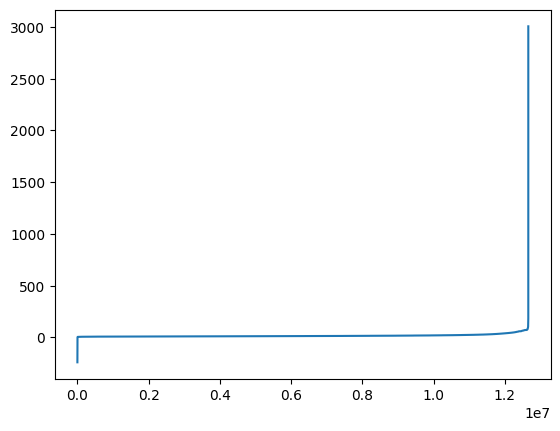

In [33]:
#below plot shows us the fare values(sorted) to find a sharp increase to remove those values as outliers
# plot the fare amount excluding last two values in sorted data
plt.plot(var[:-2])
plt.show()

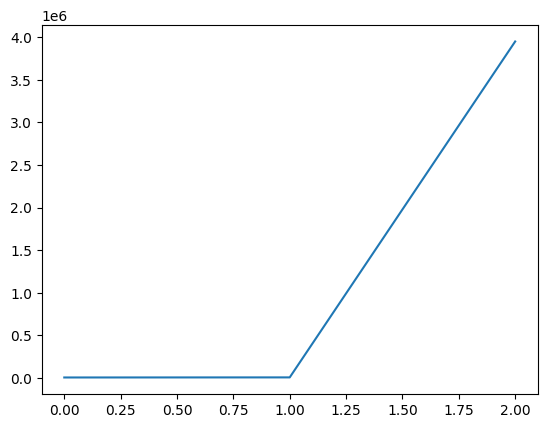

In [34]:
# a very sharp increase in fare values can be seen
# plotting last three total fare values, and we can observe there is share increase in the values
plt.plot(var[-3:])
plt.show()

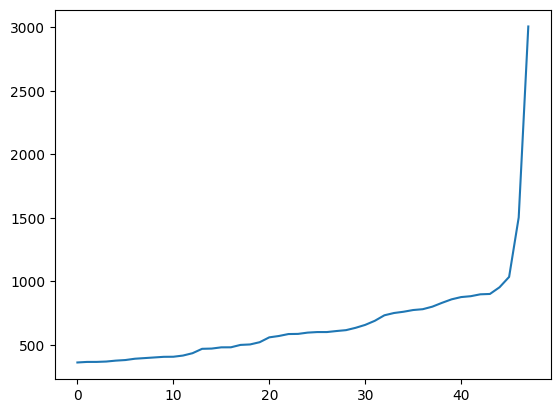

In [35]:
plt.plot(var[-50:-2])
plt.show()

### Removing all Outliers points

In [40]:
#removing all outliers based on our univariate analysis above
def remove_outliers(new_frame):


    a = new_frame.shape[0]
    print ("Number of pickup records = ",a)
    temp_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &\
                       (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & \
                       ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.5774)& \
                        (new_frame.pickup_longitude <= -73.7004) & (new_frame.pickup_latitude <= 40.9176))]

    b = temp_frame.shape[0]
    print ("Number of outlier coordinates lying outside NY boundaries:",(a-b))


    temp_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    c = temp_frame.shape[0]
    print ("Number of outliers from trip times analysis:",(a-c))


    temp_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    d = temp_frame.shape[0]
    print ("Number of outliers from trip distance analysis:",(a-d))

    temp_frame = new_frame[(new_frame.Speed <= 65) & (new_frame.Speed >= 0)]
    e = temp_frame.shape[0]
    print ("Number of outliers from speed analysis:",(a-e))

    temp_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount > 0)]
    f = temp_frame.shape[0]
    print ("Number of outliers from fare analysis:",(a-f))


    new_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude<= -73.7004) &\
                       (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & \
                       ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.5774)& \
                       (new_frame.pickup_longitude <= -73.7004) & (new_frame.pickup_latitude <= 40.9176))]

    new_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    new_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    new_frame = new_frame[(new_frame.Speed < 45.31) & (new_frame.Speed > 0)]
    new_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount > 0)]

    print ("Total outliers removed",a - new_frame.shape[0])
    print ("---")
    return new_frame

In [41]:
print ("Removing outliers in the month of Jan-2015")
print ("----")
frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)
print("fraction of data points that remain after removing outliers", float(len(frame_with_durations_outliers_removed))/len(frame_with_durations))

Removing outliers in the month of Jan-2015
----
Number of pickup records =  12748986
Number of outlier coordinates lying outside NY boundaries: 293919
Number of outliers from trip times analysis: 23889
Number of outliers from trip distance analysis: 92597
Number of outliers from speed analysis: 24473
Number of outliers from fare analysis: 5275
Total outliers removed 377910
---
fraction of data points that remain after removing outliers 0.9703576425607495


## Data Preparation

### Clustering/Segmentation

In [44]:
#trying different cluster sizes to choose the right K in K-means

coords = frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']].values
neighbours=[]

def find_min_distance(cluster_centers, cluster_len):
    nice_points = 0
    wrong_points = 0
    less2 = []
    more2 = []
    min_dist=1000
    for i in range(0, cluster_len):
        nice_points = 0
        wrong_points = 0
        for j in range(0, cluster_len):
            if j!=i:
                distance = gpxpy.geo.haversine_distance(cluster_centers[i][0], cluster_centers[i][1],cluster_centers[j][0], cluster_centers[j][1])
                min_dist = min(min_dist,distance/(1.60934*1000))
                if (distance/(1.60934*1000)) <= 2:
                    nice_points +=1
                else:
                    wrong_points += 1
        less2.append(nice_points)
        more2.append(wrong_points)
    neighbours.append(less2)
    print ("On choosing a cluster size of ",cluster_len,"\nAvg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2):", np.ceil(sum(less2)/len(less2)), "\nAvg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2):", np.ceil(sum(more2)/len(more2)),"\nMin inter-cluster distance = ",min_dist,"\n---")

def find_clusters(increment):
    kmeans = MiniBatchKMeans(n_clusters=increment, batch_size=10000,random_state=42).fit(coords)
    frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
    cluster_centers = kmeans.cluster_centers_
    cluster_len = len(cluster_centers)
    return cluster_centers, cluster_len

# we need to choose number of clusters so that, there are more number of cluster regions
#that are close to any cluster center
# and make sure that the minimum inter cluster should not be very less

for increment in range(10, 100, 10):
    cluster_centers, cluster_len = find_clusters(increment)
    find_min_distance(cluster_centers, cluster_len)

On choosing a cluster size of  10 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 2.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 7.0 
Min inter-cluster distance =  0.9942822667922672 
---
On choosing a cluster size of  20 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 5.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 14.0 
Min inter-cluster distance =  0.6444725834028739 
---
On choosing a cluster size of  30 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 9.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 21.0 
Min inter-cluster distance =  0.47920626820356643 
---
On choosing a cluster size of  40 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 11.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 29.0 
Min inter-cluster distanc

### Inference:

In [45]:
# if check for the 50 clusters you can observe that there are two clusters with only 0.3 miles apart from each other
# so we choose 20 clusters for solve the further problem

# Getting 20 clusters using the kmeans
kmeans = MiniBatchKMeans(n_clusters=20, batch_size=10000,random_state=0).fit(coords)
frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])

### Plotting the cluster centers

In [46]:
# Plotting the cluster centers on OSM
cluster_centers = kmeans.cluster_centers_
cluster_len = len(cluster_centers)
map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner', attr='Stamen')
for i in range(cluster_len):
    folium.Marker(list((cluster_centers[i][0],cluster_centers[i][1])), popup=(str(cluster_centers[i][0])+str(cluster_centers[i][1]))).add_to(map_osm)
map_osm

### Plotting the clusters

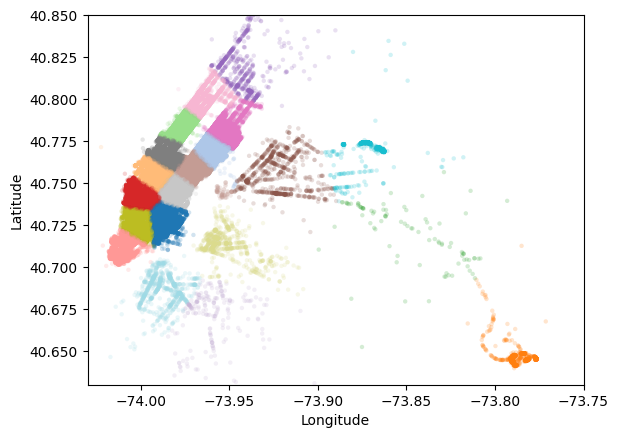

In [49]:
#Visualising the clusters on a map
def plot_clusters(frame):
    city_long_border = (-74.03, -73.75)
    city_lat_border = (40.63, 40.85)
    fig, ax = plt.subplots(ncols=1, nrows=1)
    ax.scatter(frame.pickup_longitude.values[:100000], frame.pickup_latitude.values[:100000], s=10, lw=0,
               c=frame.pickup_cluster.values[:100000], cmap='tab20', alpha=0.2)
    ax.set_xlim(city_long_border)
    ax.set_ylim(city_lat_border)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.show()

plot_clusters(frame_with_durations_outliers_removed)

### Time-Binning

In [50]:
def add_pickup_bins(frame,month,year):
    unix_pickup_times=[i for i in frame['pickup_times'].values]
    unix_times = [[1420070400,1422748800,1425168000,1427846400,1430438400,1433116800],\
                    [1451606400,1454284800,1456790400,1459468800,1462060800,1464739200]]

    start_pickup_unix=unix_times[year-2015][month-1]
    tenminutewise_binned_unix_pickup_times=[(int((i-start_pickup_unix)/600)+33) for i in unix_pickup_times]
    frame['pickup_bins'] = np.array(tenminutewise_binned_unix_pickup_times)
    return frame

In [51]:
# clustering, making pickup bins and grouping by pickup cluster and pickup bins
frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
jan_2015_frame = add_pickup_bins(frame_with_durations_outliers_removed,1,2015)
jan_2015_groupby = jan_2015_frame[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()

In [52]:
# we add two more columns 'pickup_cluster'(to which cluster it belogns to)
# and 'pickup_bins' (to which 10min intravel the trip belongs to)
jan_2015_frame.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_times,pickup_times,Speed,pickup_cluster,pickup_bins
0,1,1.59,-73.993896,40.750111,-73.974785,40.750618,17.05,18.050000,1.421349e+09,5.285319,3,2163
1,1,3.30,-74.001648,40.724243,-73.994415,40.759109,17.80,19.833333,1.420922e+09,9.983193,16,1452
2,1,1.80,-73.963341,40.802788,-73.951820,40.824413,10.80,10.050000,1.420922e+09,10.746269,13,1452
3,1,0.50,-74.009087,40.713818,-74.004326,40.719986,4.80,1.866667,1.420922e+09,16.071429,7,1452
4,1,3.00,-73.971176,40.762428,-74.004181,40.742653,16.30,19.316667,1.420922e+09,9.318378,11,1452


In [53]:
# here the trip_distance represents the number of pickups that are happend in that particular 10min intravel
# this data frame has two indices
# primary index: pickup_cluster (cluster number)
# secondary index : pickup_bins (we devid whole months time into 10min intravels 24*31*60/10 =4464bins)
jan_2015_groupby.head()

trip_distance
pickup_cluster pickup_bins               
0              33                     313
               34                     561
               35                     629
               36                     601
               37                     610

In [54]:
# upto now we cleaned data and prepared data for the month 2015,

# now do the same operations for Jan of 2016
# 1. get the dataframe which inlcudes only required colums
# 2. adding trip times, speed, unix time stamp of pickup_time
# 4. remove the outliers based on trip_times, speed, trip_duration, total_amount
# 5. add pickup_cluster to each data point
# 6. add pickup_bin (index of 10min intravel to which that trip belongs to)
# 7. group by data, based on 'pickup_cluster' and 'pickuo_bin'

# Data Preparation for the months of Jan,Feb and March 2016
def datapreparation(month,kmeans,month_no,year_no):

    print ("Return with trip times..")

    frame_with_durations = return_with_trip_times(month)

    print ("Remove outliers..")
    frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)

    print ("Estimating clusters..")
    frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
    #frame_with_durations_outliers_removed_2016['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed_2016[['pickup_latitude', 'pickup_longitude']])

    print ("Final groupbying..")
    final_updated_frame = add_pickup_bins(frame_with_durations_outliers_removed,month_no,year_no)
    final_groupby_frame = final_updated_frame[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()

    return final_updated_frame,final_groupby_frame



In [55]:
month_jan_2016=dd.read_csv('/content/drive/MyDrive/Colab Datasets/yellow_tripdata_2016-01.csv',dtype={'store_and_fwd_flag': 'object'})

In [56]:
jan_2016_frame,jan_2016_groupby = datapreparation(month_jan_2016,kmeans,1,2016)

Return with trip times..
Remove outliers..
Number of pickup records =  10906858
Number of outlier coordinates lying outside NY boundaries: 214677
Number of outliers from trip times analysis: 27190
Number of outliers from trip distance analysis: 79742
Number of outliers from speed analysis: 21047
Number of outliers from fare analysis: 4991
Total outliers removed 297784
---
Estimating clusters..
Final groupbying..


### Smoothing

In [57]:
def return_unq_pickup_bins(frame):
    values = []
    for i in range(0,40):
        new = frame[frame['pickup_cluster'] == i]
        list_unq = list(set(new['pickup_bins']))
        list_unq.sort()
        values.append(list_unq)
    return values

In [58]:
# For jan 2016 month, we get all indices of 10-min intervals in which atleast one pickup happened
jan_2015_unique = return_unq_pickup_bins(jan_2015_frame)
jan_2016_unique = return_unq_pickup_bins(jan_2016_frame)

In [59]:
# For each cluster, number of 10-min intervals with 0 pickups
for i in range(40):
    print("For the", i, "th cluster, number of 10-min intervals with 0 pickups:", 4464 - len(set(jan_2015_unique[i])))

For the 0 th cluster, number of 10-min intervals with 0 pickups: 27
For the 1 th cluster, number of 10-min intervals with 0 pickups: 25
For the 2 th cluster, number of 10-min intervals with 0 pickups: 144
For the 3 th cluster, number of 10-min intervals with 0 pickups: 29
For the 4 th cluster, number of 10-min intervals with 0 pickups: 493
For the 5 th cluster, number of 10-min intervals with 0 pickups: 37
For the 6 th cluster, number of 10-min intervals with 0 pickups: 29
For the 7 th cluster, number of 10-min intervals with 0 pickups: 33
For the 8 th cluster, number of 10-min intervals with 0 pickups: 26
For the 9 th cluster, number of 10-min intervals with 0 pickups: 258
For the 10 th cluster, number of 10-min intervals with 0 pickups: 26
For the 11 th cluster, number of 10-min intervals with 0 pickups: 19
For the 12 th cluster, number of 10-min intervals with 0 pickups: 16
For the 13 th cluster, number of 10-min intervals with 0 pickups: 35
For the 14 th cluster, number of 10-min i

In [60]:
# Fills a value of 0 for every bin, where no pickup data is present
# count_values: #pickps that happened in each region for each 10-min interval
# There won't be any value if there are no pickups
# values: Unique bins' indices for every cluster

# For every 10-min interval (pickup_bin), we will check if it is there in our unique bin
# If it is there, we will add the count_values[index] to smoothed data
# If not, we will add 0 to the smoothed data
# We finally return smoothed data

def fill_missing(count_values, values):
    smoothed_regions = []
    ind = 0
    for r in range(0,40):
        smoothed_bins = []
        for i in range(4464):
            if i in values[r]:
                smoothed_bins.append(count_values[ind])
                ind += 1
            else:
                smoothed_bins.append(0)
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions

In [61]:
# Fills the average value for every bin, where no pickup data is present
# count_values: #pickps that happened in each region for each 10-min interval
# There won't be any value if there are no pickups
# values: Unique bins' indices for every cluster

# For every 10-min interval (pickup_bin), we will check if it is there in our unique bin
# If it is there, we will add the count_values[index] to smoothed data
# If not, we will add smoothed data (which is calculated based on the methods that are discussed
# in the above markdown cell), and then, we finally return the smoothed data

def smoothing(count_values,values):
    # Stores list of final smoothed values of each region
    smoothed_regions = []
    ind = 0
    repeat = 0
    smoothed_value = 0
    for r in range(0,40):
        smoothed_bins = [] # Stores the final smoothed values
        repeat = 0
        for i in range(4464):
            # Prevents iteration for a value which is already visited/resolved
            if repeat != 0:
              repeat -= 1;
              continue

            # Checks if the pickup-bin exists. Appends the value of the pickup bin if it exists
            if i in values[r]:
              smoothed_bins.append(count_values[ind])

            # If the pickup bin doesn't exist
            else:
                if i != 0:
                    right_hand_limit = 0
                    for j in range(i, 4464):
                        # Searches for the left-limit or the pickup-bin value which has a pickup value
                        if  j not in values[r]:
                          continue
                        else:
                          right_hand_limit = j;
                          break
                    # Case 1: When we have the last/last few values are found to be missing, & hence we have no right-limit here
                    if right_hand_limit == 0:
                        smoothed_value = count_values[ind-1]*1.0 / ((4463-i)+2)*1.0
                        for j in range(i, 4464):
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat = (4463-i)
                        ind -= 1
                    else:
                    # Case 2: When we have the missing values between two known values
                        smoothed_value = (count_values[ind-1] + count_values[ind])*1.0 / ((right_hand_limit-i)+2)*1.0
                        for j in range(i, right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(right_hand_limit-i)
                else:
                    # Case 3: When we have the first/first few values are found to be missing, hence we have no left-limit here
                    right_hand_limit = 0
                    for j in range(i,4464):
                        if j not in values[r]:
                          continue
                        else:
                          right_hand_limit = j;
                          break
                    smoothed_value = count_values[ind]*1.0 / ((right_hand_limit-i)+1)*1.0
                    for j in range(i, right_hand_limit+1):
                        smoothed_bins.append(math.ceil(smoothed_value))
                    repeat = (right_hand_limit - i)
            ind += 1
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions

In [62]:
# Filling Missing values of Jan-2015 with 0
jan_2015_fill = fill_missing(jan_2015_groupby['trip_distance'].values, jan_2015_unique)

# Smoothing Missing values of Jan-2015
jan_2015_smooth = smoothing(jan_2015_groupby['trip_distance'].values, jan_2015_unique)

In [63]:
# Number of 10-min indices for Jan 2015: 24*31*60/10 = 4464
# Number of 10-min indices for Jan 2016: 24*31*60/10 = 4464
# For each cluster we will have 4464 values, therefore 40*4464 = 178560 (Length of the jan_2015_fill)
print("Number of 10-min intervals among all the clusters:", len(jan_2015_fill))

Number of 10-min intervals among all the clusters: 178560


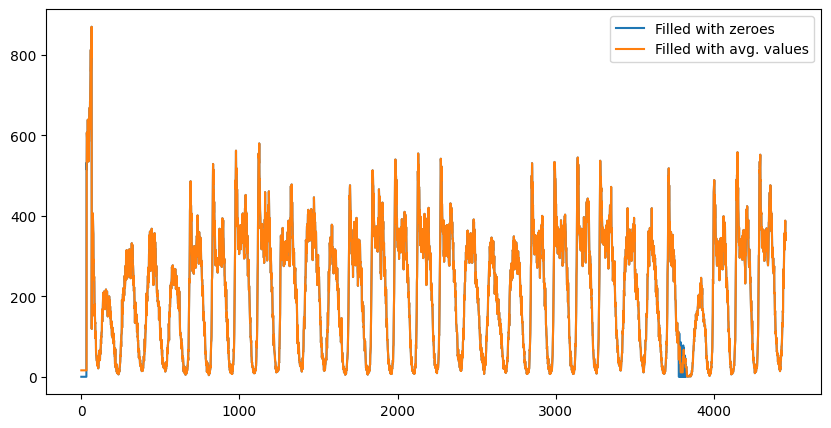

In [64]:
# Smoothing vs Filling
# Sample plot that shows two variations of filling missing values
# We have taken the #pickups for cluster region 2
plt.figure(figsize = (10,5))
plt.plot(jan_2015_fill[4464:8920], label="Filled with zeroes")
plt.plot(jan_2015_smooth[4464:8920], label="Filled with avg. values")
plt.legend()
plt.show()

In [65]:
# Jan-2015 data is smoothed, Jan 2016 data missing values are filled with zeroes
jan_2015_smooth = smoothing(jan_2015_groupby['trip_distance'].values, jan_2015_unique)
jan_2016_smooth = fill_missing(jan_2016_groupby['trip_distance'].values, jan_2016_unique)

# Making list of all the values of pickup data in every bin for jan month 2016,
# and storing them region-wise.
# regions_cum: It will contain 40 lists, each list will contain 4464 + 4176 + 4464 values,
# which represents the #pickups, that have happened for three months in 2016 data
regions_cum = []

# Number of 10-min indices for Jan 2015: 24*31*60/10 = 4464
# Number of 10-min indices for Jan 2016: 24*31*60/10 = 4464

for i in range(0, 40):
    regions_cum.append(jan_2016_smooth[4464*i:4464*(i+1)])

print(len(regions_cum))
print(len(regions_cum[0]))

40
4464


### Time Series & Fourier Transforms

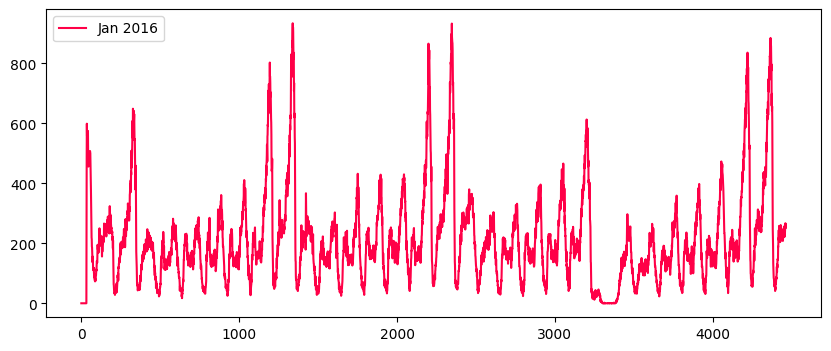

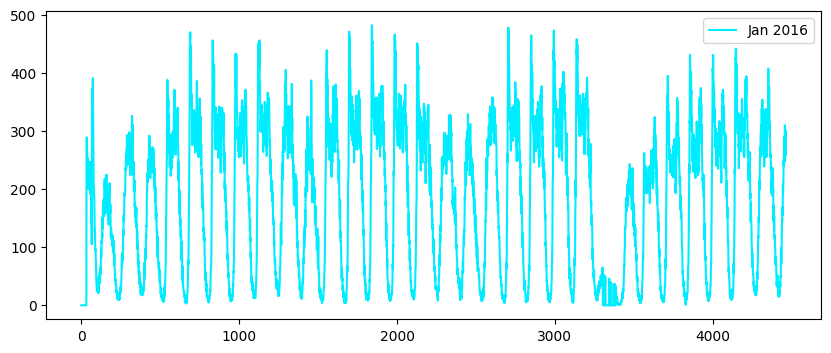

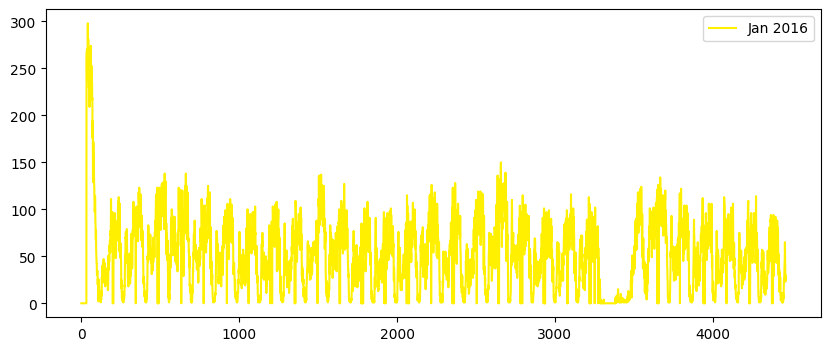

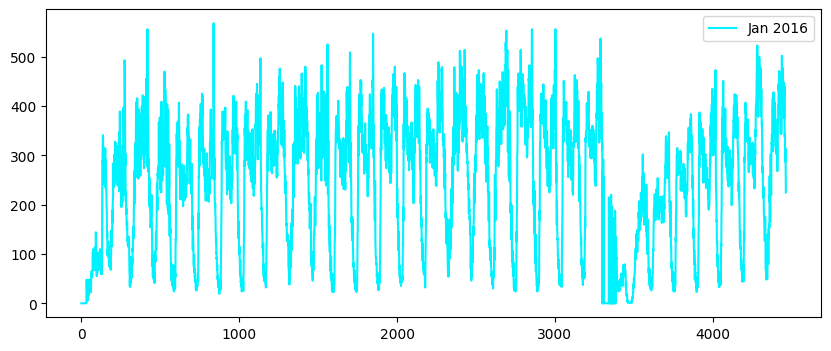

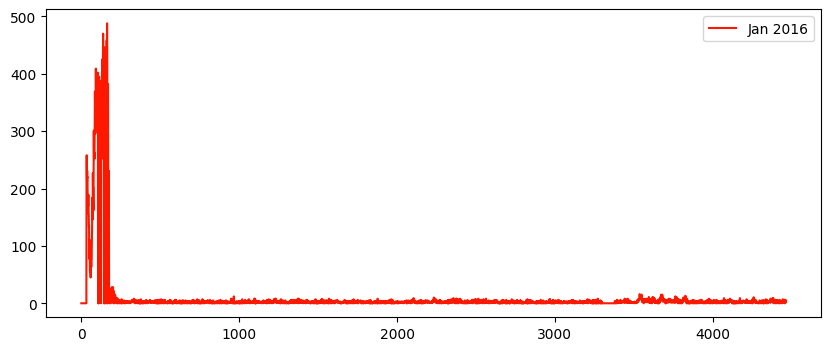

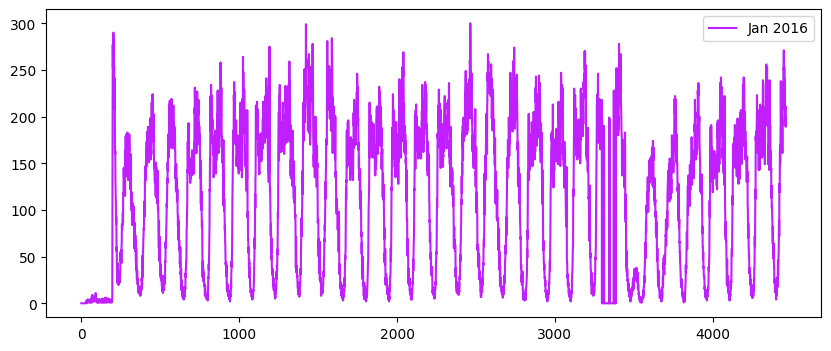

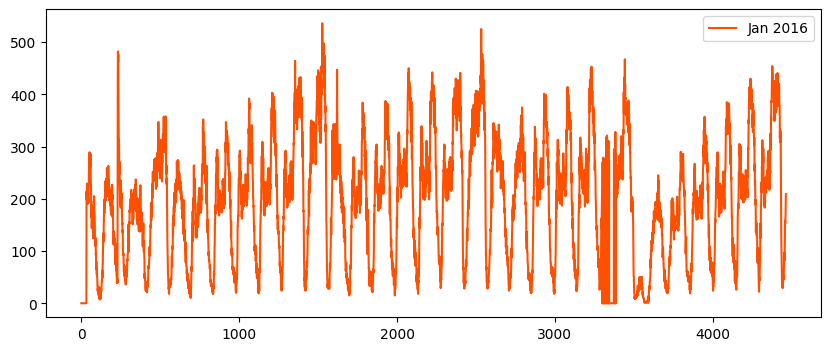

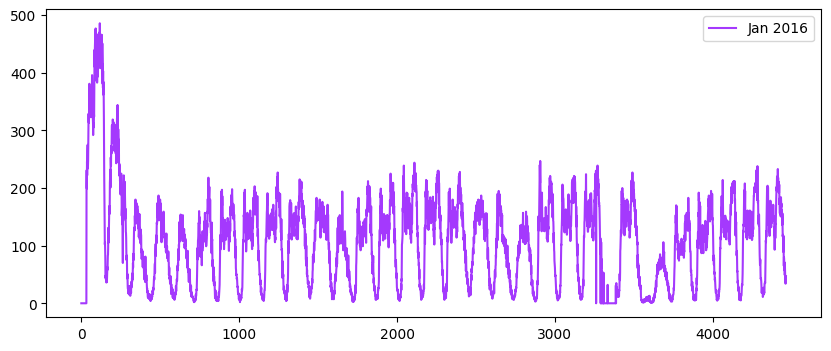

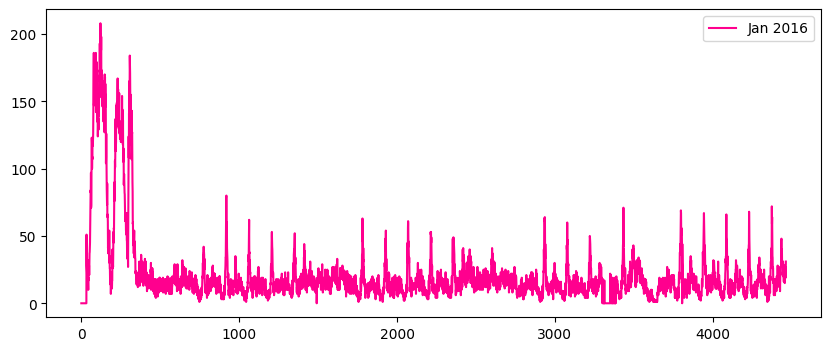

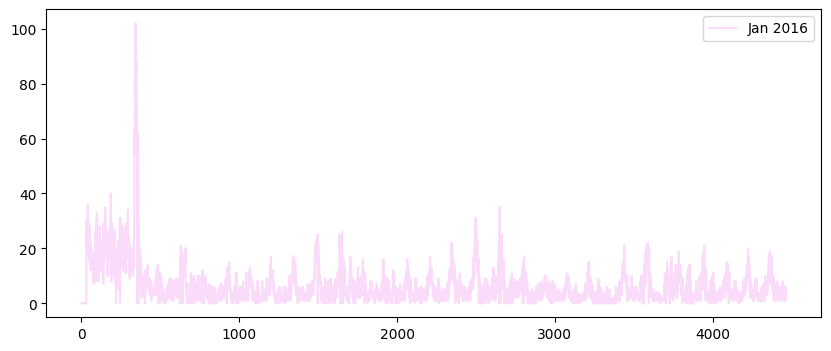

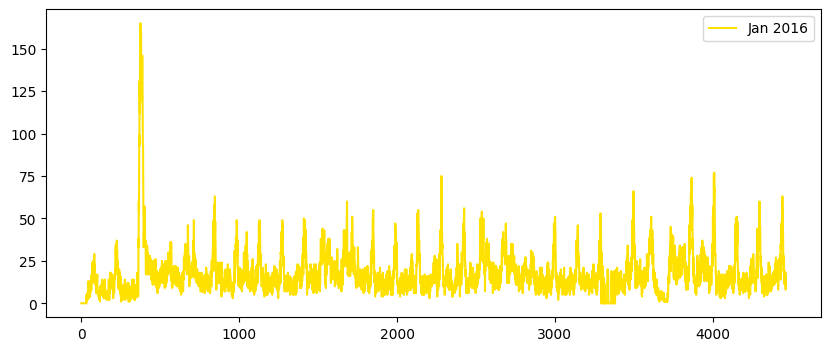

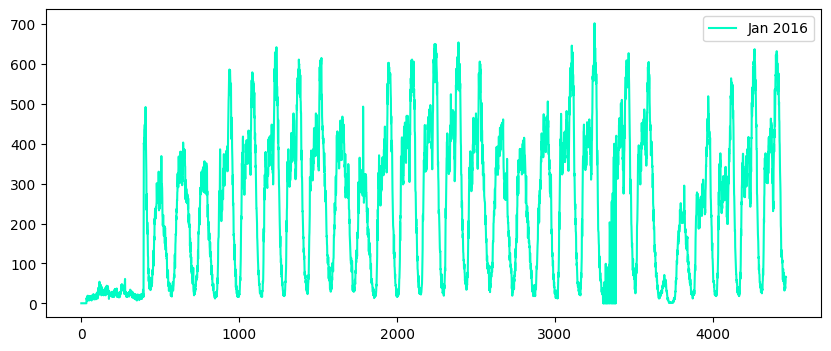

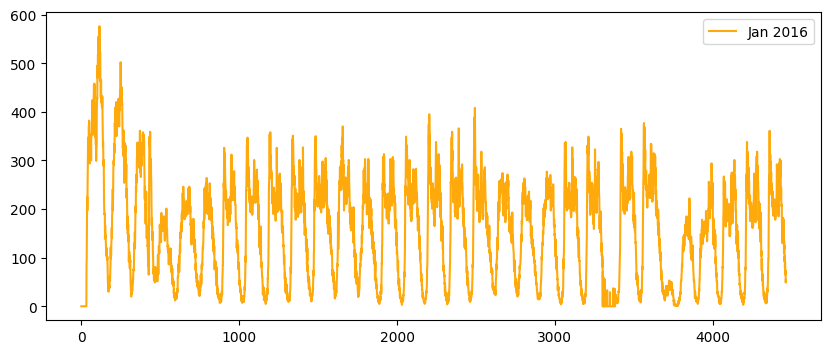

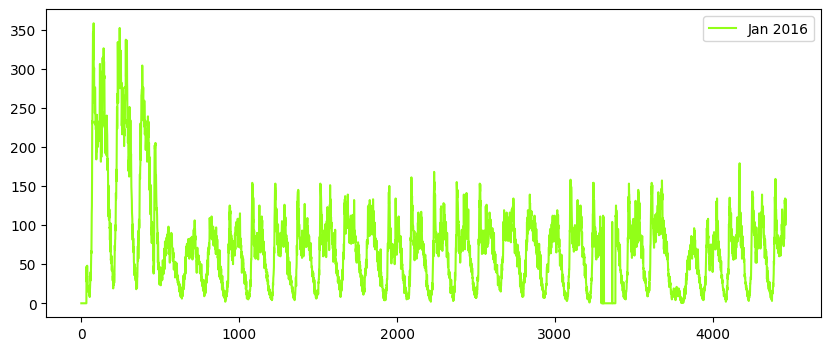

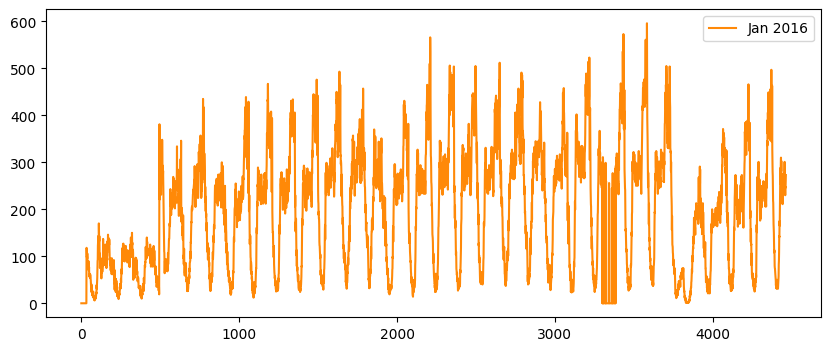

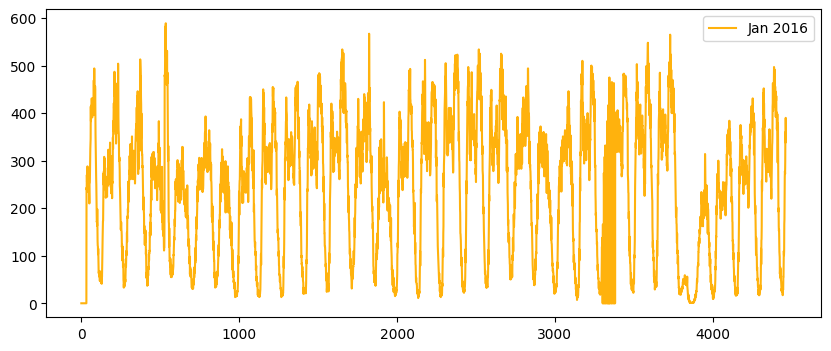

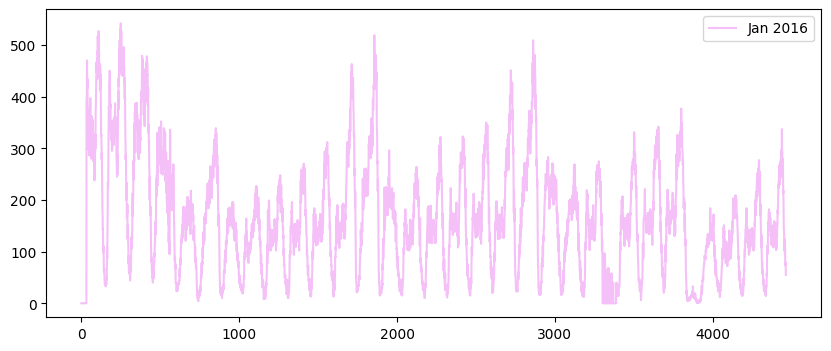

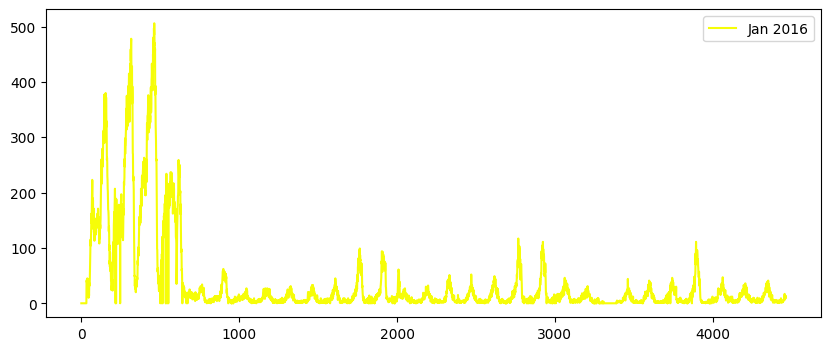

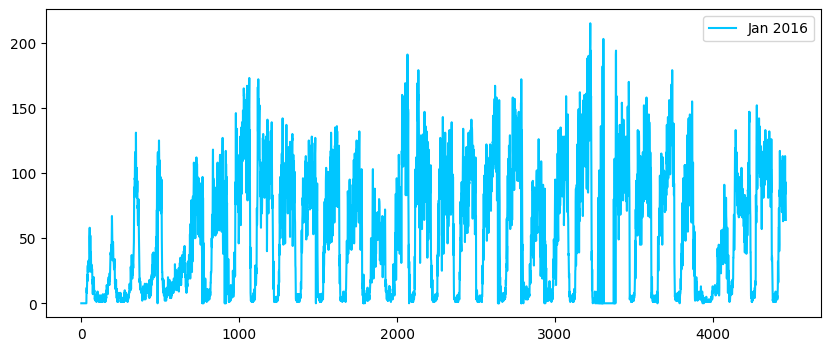

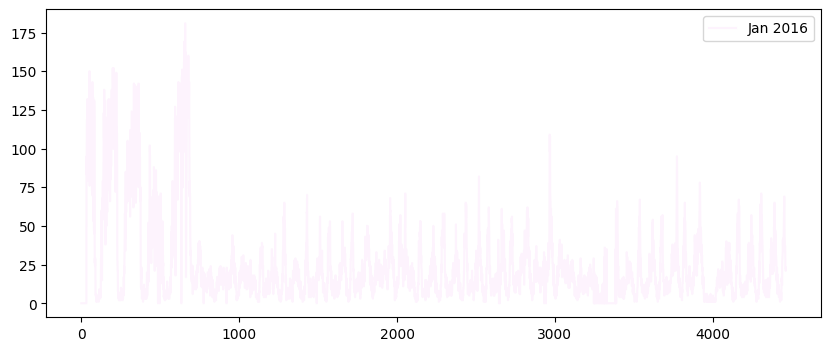

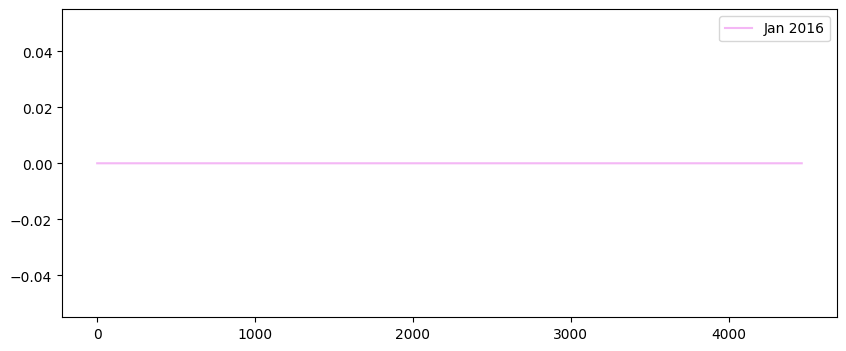

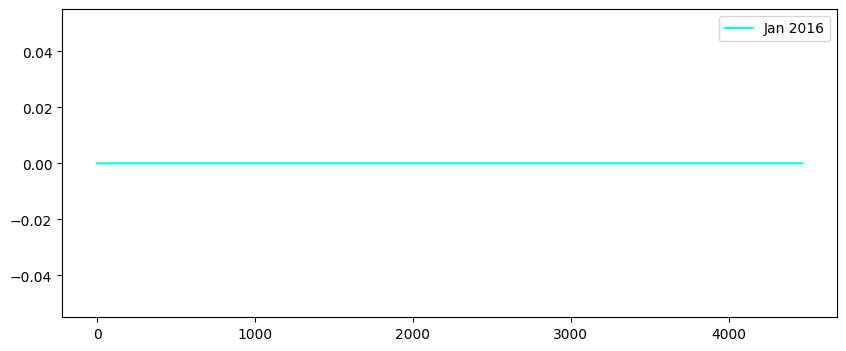

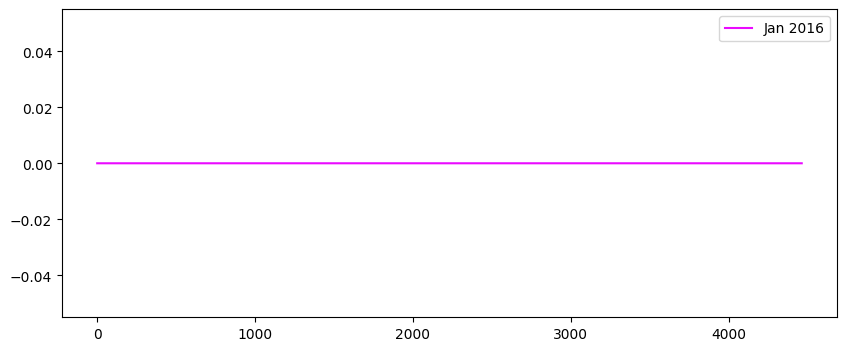

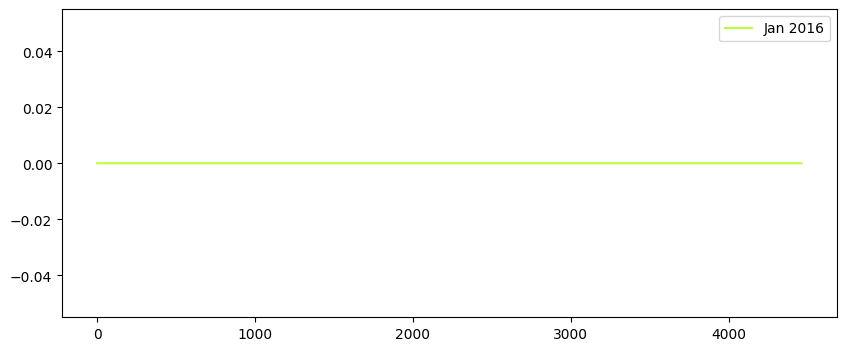

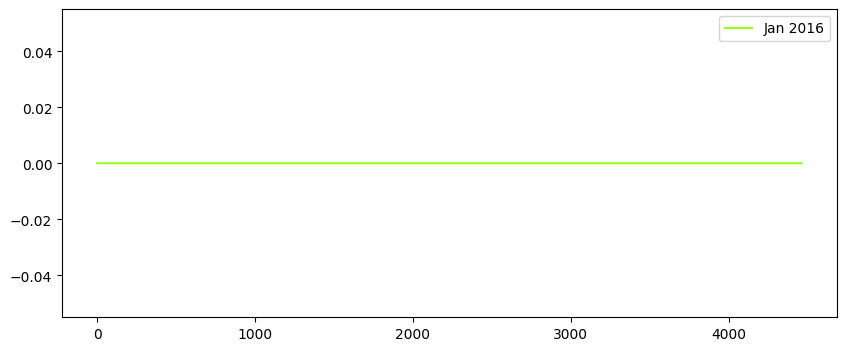

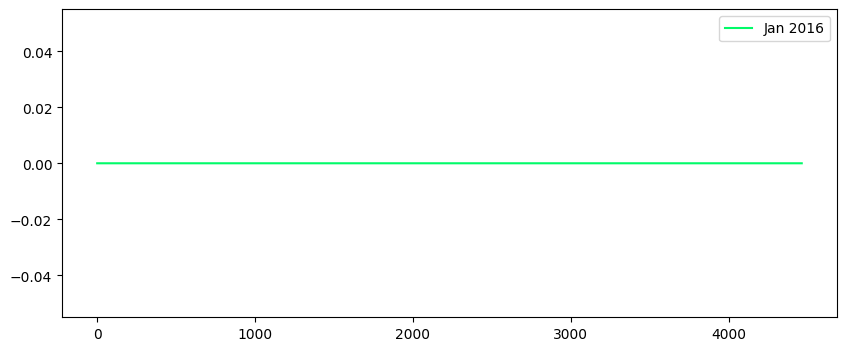

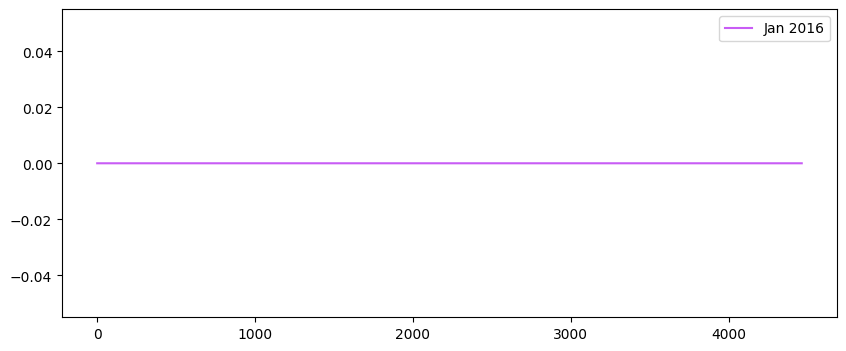

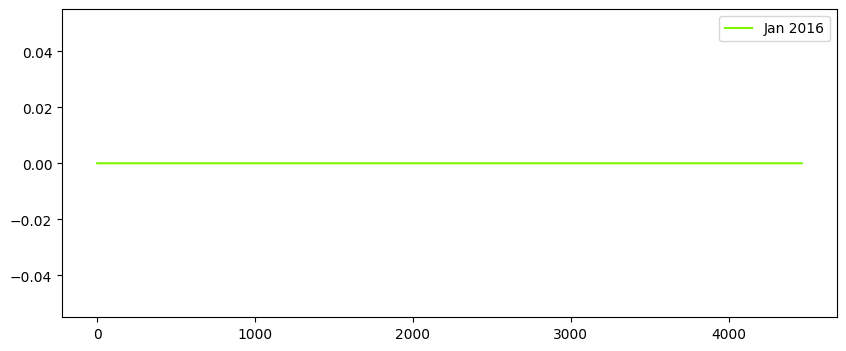

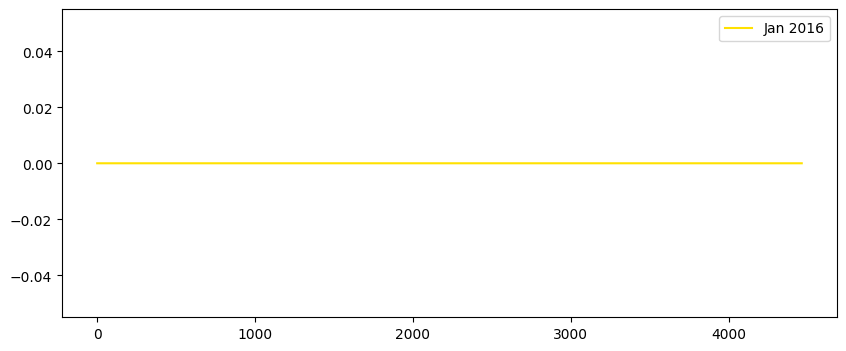

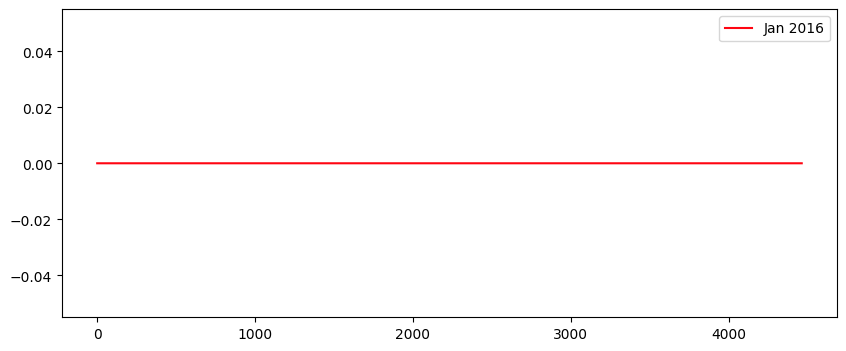

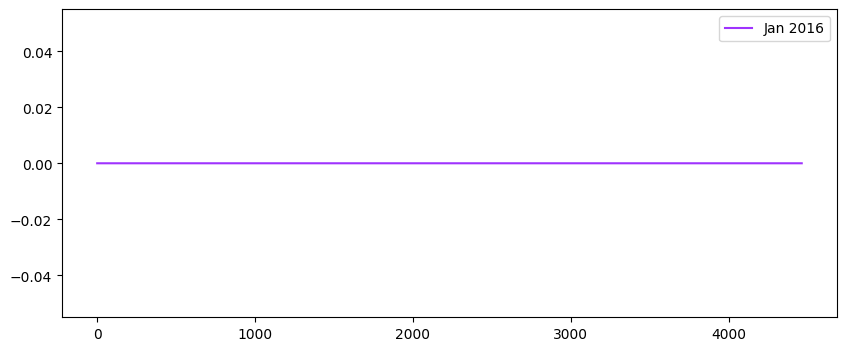

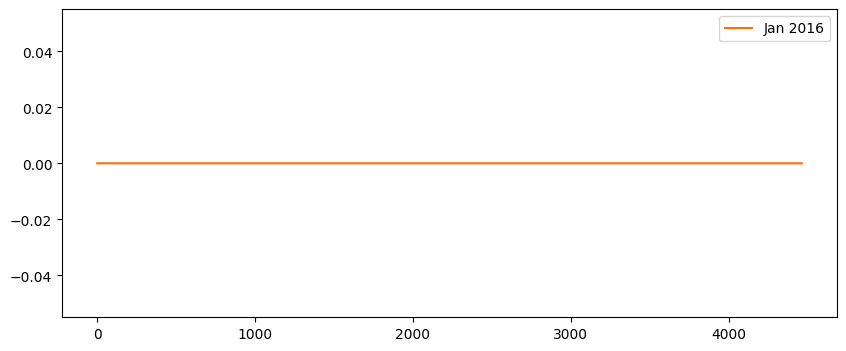

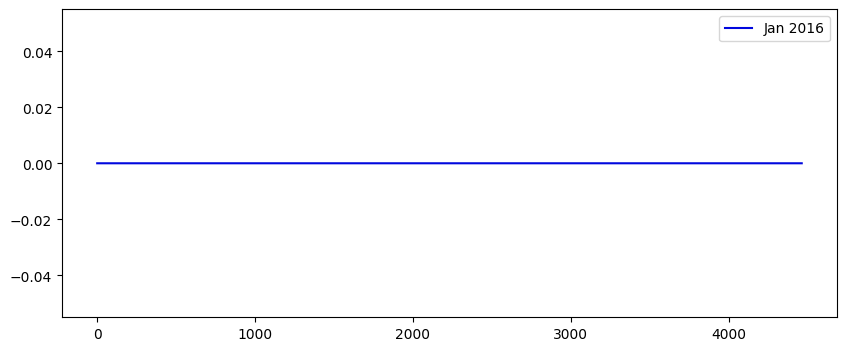

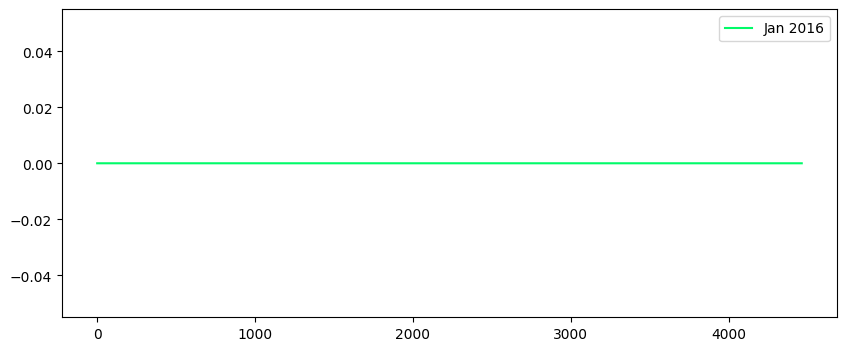

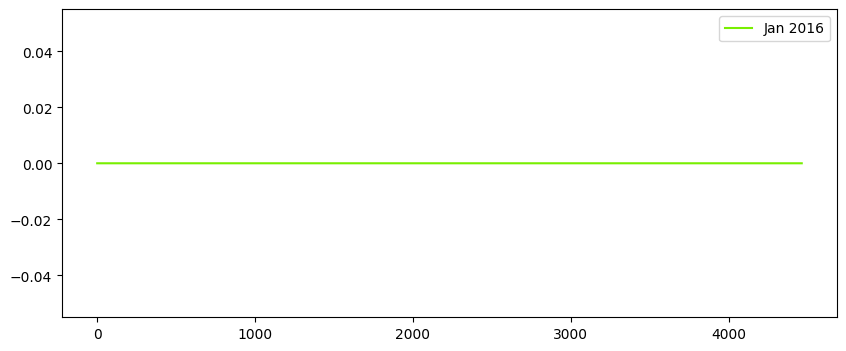

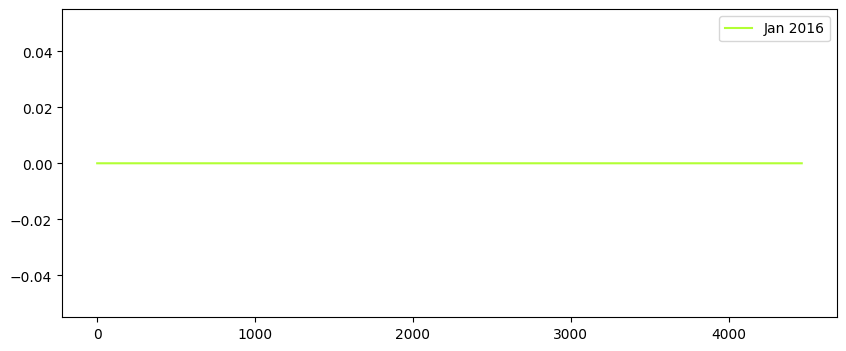

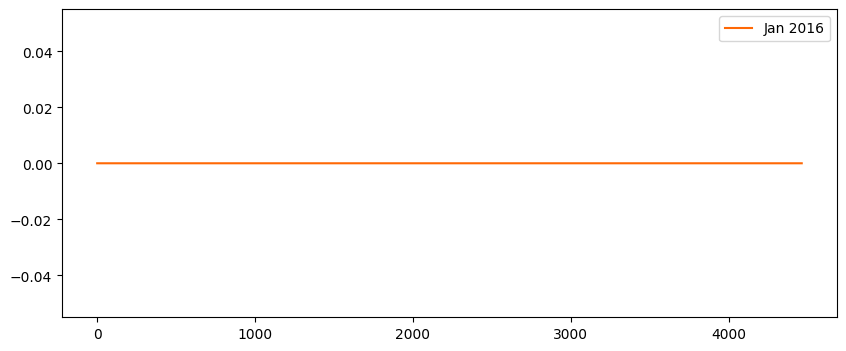

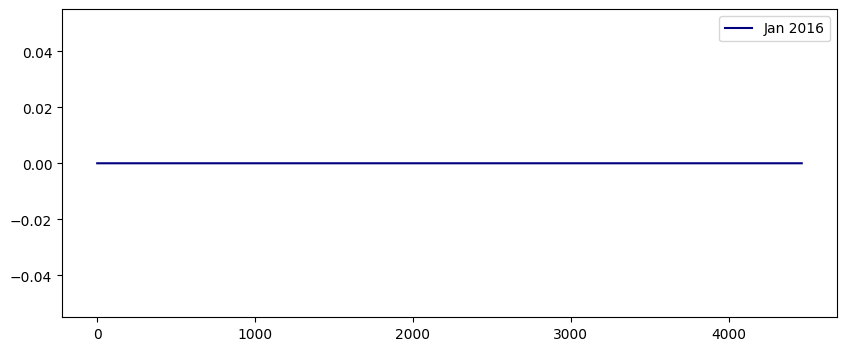

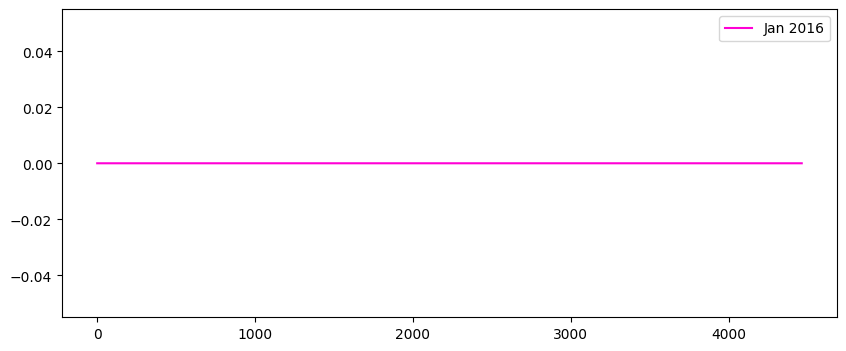

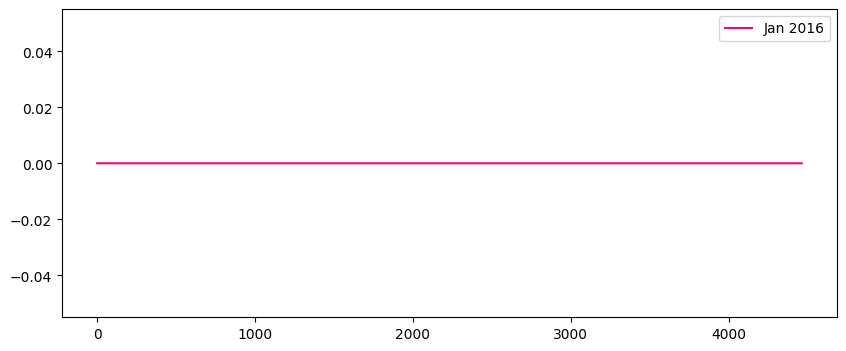

In [66]:
# A function to generate unique colors
def uniqueish_color():
    return plt.cm.gist_ncar(np.random.random())

first_x = list(range(0,4464))


for i in range(40):
    plt.figure(figsize = (10,4))
    plt.plot(first_x,regions_cum[i][:4464], color = uniqueish_color(), label='Jan 2016')
    plt.legend()
    plt.show()

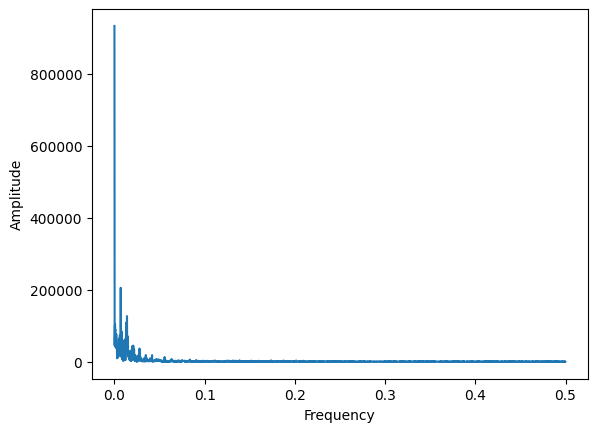

In [67]:
Y = np.fft.fft(np.array(jan_2016_smooth)[0:4460])
freq = np.fft.fftfreq(4460, 1)
n = len(freq)
plt.figure()
plt.plot(freq[:int(n/2)], np.abs(Y)[:int(n/2)])
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()

#### Visualizing Detection of Peaks

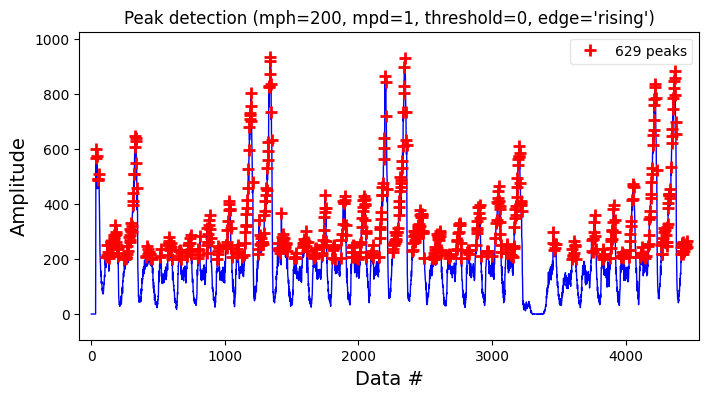

In [68]:
indexes_jan2016 = detect_peaks(regions_cum[0][:4464], mph = 200, show=True)

#### Integrating Fourier Transform Based Features

In [69]:
'''def extract_fft_features(cluster, month):
    """
    The `fft` function when returns the DFT, the sampling frequencies are in the form of
    +- f1, -+ f2, and so on. So, when we will be considering the frequencies corresponding to
    the highest peaks, we will consider the positive counterparts only. (If you want, you can
    consider the negative counterparts only, as well)
    """

    # Creating an empty list for the 4 features
    features = []

    Y = np.fft.fft(regions_cum[cluster][0:4464])  # Use regions_cum[cluster] instead of jan_2016_smooth
    freq = np.fft.fftfreq(4464, 1)



    # `indexes` contains the indices of the peaks
    indexes = detect_peaks(Y, mph = 1000, show = True)

    # Number of peaks is the first feature
    features.append(len(indexes))

    if len(indexes) != 0:
        # Getting the Amplitude and Frequency of the Peaks using the `indexes`
        amp_peaks = np.abs(Y[indexes])
        freq_peaks = freq[indexes]

        # Getting the Indices which would sort the amp_peaks array
        # Since the Indices sort the array in the Increasing Order, hence reversing the array of indices
        sorted_ind = np.argsort(amp_peaks)
        sorted_ind = sorted_ind[ : :-1]

        # Contains the frequencies of the Highest Peaks in order
        high_peak_freq = np.take(freq_peaks, sorted_ind)

        for i in range(0, 6, 2):
            if i < len(high_peak_freq): features.append(np.abs(high_peak_freq[i]))
            else: features.append(0)

    else: features.extend([0, 0, 0])
    return features


# Creating an empty numpy array, sto store the FFT-based features
fft_feat = np.empty([40, 13104, 4])

for i in range(40):
    features = extract_fft_features(i, 0)
    fft_feat[i][:4464] = features
    features = extract_fft_features(i, 1)
    fft_feat[i][4464:8640] = features
    features = extract_fft_features(i, 2)
    fft_feat[i][8640:] = features'''

'def extract_fft_features(cluster, month):\n    """\n    The `fft` function when returns the DFT, the sampling frequencies are in the form of\n    +- f1, -+ f2, and so on. So, when we will be considering the frequencies corresponding to\n    the highest peaks, we will consider the positive counterparts only. (If you want, you can\n    consider the negative counterparts only, as well)\n    """\n\n    # Creating an empty list for the 4 features\n    features = []\n\n    Y = np.fft.fft(regions_cum[cluster][0:4464])  # Use regions_cum[cluster] instead of jan_2016_smooth\n    freq = np.fft.fftfreq(4464, 1)\n\n\n\n    # `indexes` contains the indices of the peaks\n    indexes = detect_peaks(Y, mph = 1000, show = True)\n\n    # Number of peaks is the first feature\n    features.append(len(indexes))\n\n    if len(indexes) != 0:\n        # Getting the Amplitude and Frequency of the Peaks using the `indexes`\n        amp_peaks = np.abs(Y[indexes])\n        freq_peaks = freq[indexes]\n\n        #

## Modelling: Baseline Models

In [70]:
# Preparing the Dataframe only with x(i) values as Jan 2015 data and y(i) values as Jan 2016
ratios_jan = pd.DataFrame()
ratios_jan['Given'] = jan_2015_smooth
ratios_jan['Prediction'] = jan_2016_smooth
ratios_jan['Ratios'] = ratios_jan['Prediction']*1.0 / ratios_jan['Given']*1.0

### Simple Moving Averages

In [83]:
def MA_R_Predictions(ratios):
    predicted_ratio = (ratios['Ratios'].values)[0]
    error, predicted_values, predicted_ratio_values = [], [], []
    window_size = 3
    for i in range(0, 4464*40):
        if i % 4464 == 0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_val = int(((ratios['Given'].values)[i])*predicted_ratio)
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(predicted_val)
        error.append( abs(predicted_val-(ratios['Prediction'].values)[i]) )
        if i+1 >= window_size:
            predicted_ratio = sum((ratios['Ratios'].values)[(i+1)-window_size:(i+1)]) / window_size
        else:
            predicted_ratio = sum((ratios['Ratios'].values)[0:(i+1)]) / (i+1)

    ratios['MA_R_Predicted'] = predicted_values
    ratios['MA_R_Error'] = error

    avg_pred_val = (sum(ratios['Prediction'].values) / len(ratios['Prediction'].values))
    mape_err = (1 / len(error)) * (sum(error) / avg_pred_val)
    mse_err = sum([e**2 for e in error]) / len(error)
    return ratios, mape_err, mse_err

In [72]:
def MA_P_Predictions(ratios):
    predicted_value = (ratios['Prediction'].values)[0]
    error, predicted_values = [], []
    window_size = 1
    for i in range(0, 4464*40):
        predicted_values.append(predicted_value)
        error.append(abs(predicted_value-(ratios['Prediction'].values)[i]))
        if i+1 >= window_size:
            predicted_value = int(sum((ratios['Prediction'].values)[(i+1)-window_size:(i+1)]) / window_size)
        else:
            predicted_value = int(sum((ratios['Prediction'].values)[0:(i+1)]) / (i+1))

    ratios['MA_P_Predicted'] = predicted_values
    ratios['MA_P_Error'] = error

    avg_pred_val = (sum(ratios['Prediction'].values) / len(ratios['Prediction'].values))
    mape_err = (1 / len(error)) * (sum(error) / avg_pred_val)
    mse_err = sum([e**2 for e in error]) / len(error)
    return ratios, mape_err, mse_err

### Weighted Moving Averages

In [73]:
def WA_R_Predictions(ratios):
    predicted_ratio=(ratios['Ratios'].values)[0]
    alpha, window_size = 0.5, 5
    error, predicted_values, predicted_ratio_values = [], [], []
    for i in range(0, 4464*40):
        if i%4464 == 0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_val = int(((ratios['Given'].values)[i])*predicted_ratio)
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(predicted_val)
        error.append( abs(predicted_val-(ratios['Prediction'].values)[i]) )

        sum_values = 0
        sum_of_coeff = 0
        if i+1 >= window_size:
            for j in range(window_size, 0, -1):
                sum_values += j*(ratios['Ratios'].values)[i-window_size+j]
                sum_of_coeff += j
        else:
            for j in range(i+1, 0, -1):
                sum_values += j*(ratios['Ratios'].values)[j-1]
                sum_of_coeff += j

        predicted_ratio = sum_values / sum_of_coeff

    ratios['WA_R_Predicted'] = predicted_values
    ratios['WA_R_Error'] = error
    avg_pred_val = (sum(ratios['Prediction'].values) / len(ratios['Prediction'].values))
    mape_err = (1 / len(error)) * (sum(error) / avg_pred_val)
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios, mape_err, mse_err

In [75]:
def WA_P_Predictions(ratios):
    predicted_value=(ratios['Prediction'].values)[0]
    error, predicted_values = [], []
    window_size = 2
    for i in range(0, 4464*40):
        predicted_values.append(predicted_value)
        error.append(abs(predicted_value-(ratios['Prediction'].values)[i]))

        sum_values = 0
        sum_of_coeff = 0
        if i+1 >= window_size:
            for j in range(window_size, 0, -1):
                sum_values += j*(ratios['Prediction'].values)[i-window_size+j]
                sum_of_coeff += j

        else:
            for j in range(i+1,0,-1):
                sum_values += j*(ratios['Prediction'].values)[j-1]
                sum_of_coeff+=j

        predicted_value = int(sum_values / sum_of_coeff)

    ratios['WA_P_Predicted'] = predicted_values
    ratios['WA_P_Error'] = error
    avg_pred_val = (sum(ratios['Prediction'].values) / len(ratios['Prediction'].values))
    mape_err = (1 / len(error)) * (sum(error) / avg_pred_val)
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios, mape_err, mse_err

### Exponential Weighted Moving Averages

In [76]:
def EA_R1_Predictions(ratios):
    predicted_ratio=(ratios['Ratios'].values)[0]
    alpha = 0.6
    error, predicted_values, predicted_ratio_values = [], [], []
    for i in range(0, 4464*40):
        if i % 4464 == 0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_val = int(((ratios['Given'].values)[i])*predicted_ratio)
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(predicted_val)
        error.append(abs((predicted_val - (ratios['Prediction'].values)[i])))
        predicted_ratio = (alpha*predicted_ratio) + (1-alpha)*((ratios['Ratios'].values)[i])

    ratios['EA_R1_Predicted'] = predicted_values
    ratios['EA_R1_Error'] = error
    avg_pred_val = (sum(ratios['Prediction'].values) / len(ratios['Prediction'].values))
    mape_err = (1 / len(error)) * (sum(error) / avg_pred_val)
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios, mape_err, mse_err

In [77]:
def EA_P1_Predictions(ratios):
    predicted_value= (ratios['Prediction'].values)[0]
    alpha = 0.3
    error, predicted_values = [], []
    for i in range(0, 4464*40):
        if i % 4464 == 0:
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_values.append(predicted_value)
        error.append(abs((predicted_value-(ratios['Prediction'].values)[i])))
        predicted_value =int((alpha*predicted_value) + (1-alpha)*((ratios['Prediction'].values)[i]))

    ratios['EA_P1_Predicted'] = predicted_values
    ratios['EA_P1_Error'] = error
    avg_pred_val = (sum(ratios['Prediction'].values) / len(ratios['Prediction'].values))
    mape_err = (1 / len(error)) * (sum(error) / avg_pred_val)
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios, mape_err, mse_err

In [85]:
mape_err = [0]*10
mse_err = [0]*10
ratios_jan, mape_err[0], mse_err[0] = MA_R_Predictions(ratios_jan)
ratios_jan, mape_err[1], mse_err[1] = MA_P_Predictions(ratios_jan)
ratios_jan, mape_err[2], mse_err[2] = WA_R_Predictions(ratios_jan)
ratios_jan, mape_err[3], mse_err[3] = WA_P_Predictions(ratios_jan)
ratios_jan, mape_err[4], mse_err[4] = EA_R1_Predictions(ratios_jan)
ratios_jan, mape_err[5], mse_err[5] = EA_P1_Predictions(ratios_jan)

### Comparison between baseline models

In [86]:
x = PrettyTable()

x.field_names = ["Baseline Model", "MAPE", "MSE"]
x.add_rows([
    ["Simple Moving Averages (Ratios)", mape_err[0], mse_err[0]],
    ["Simple Moving Averages (2016 Values)", mape_err[1], mse_err[1]],
    ["Weighted Moving Averages (Ratios)", mape_err[2], mse_err[2]],
    ["Weighted Moving Averages (2016 Values)", mape_err[3], mse_err[3]],
    ["Exponential Weighted Moving Averages (Ratios)", mape_err[4], mse_err[4]],
    ["Exponential Weighted Moving Averages (2016 Values)", mape_err[5], mse_err[5]]
])

print ("Error Metric Matrix (Forecasting Methods) - MAPE & MSE")
print(x)

Error Metric Matrix (Forecasting Methods) - MAPE & MSE
+----------------------------------------------------+---------------------+--------------------+
|                   Baseline Model                   |         MAPE        |        MSE         |
+----------------------------------------------------+---------------------+--------------------+
|          Simple Moving Averages (Ratios)           |  0.1675172857471233 | 2075.221611783154  |
|        Simple Moving Averages (2016 Values)        | 0.11078907211327198 | 284.79564292114696 |
|         Weighted Moving Averages (Ratios)          | 0.16894479652873784 | 1666.4023241487455 |
|       Weighted Moving Averages (2016 Values)       | 0.10852801284589783 | 266.0126680107527  |
|   Exponential Weighted Moving Averages (Ratios)    | 0.16889193275161152 | 1683.2102542562725 |
| Exponential Weighted Moving Averages (2016 Values) | 0.10865129872612457 | 263.8137432795699  |
+----------------------------------------------------+---------

## Regression Models

### Preparing Data & Performing Train-Test Split

In [89]:
# Number of 10-min indices for Jan 2016: 24*31*60/10 = 4464
# Number of 10-min indices for Feb 2016: 24*29*60/10 = 4176
# Number of 10-min indices for Mar 2016: 24*31*60/10 = 4464
# regions_cum: It will contain 40 lists, each list will contain (4464+4176+4464) = 13104 values
# which represents the #pickups that have happened for three months in 2016.

# Since, we are considering the #pickups for the last 5 time-bins, hence, we are omitting the
# first 5 time bins from our dataframe, and therefore, our prediction starts from 5th 10-min interval


# We take #pickups that have happened in last 5 10-min intervals
number_of_time_stamps = 5

# It is a list of lists
# It will contain 13099 #pickups for each cluster
output = []

# tsne_lat will contain 13099 times latitude of cluster center for every cluster
# Ex: [[cent_lat 13099times], [cent_lat 13099times], [cent_lat 13099times] .... 40 lists]
# It is a list of lists
tsne_lat = []


# tsne_lon will contain 13099 times longitude of cluster center for every cluster
# Ex: [[cent_long 13099times], [cent_long 13099times], [cent_long 13099times] .... 40 lists]
# It is a list of lists
tsne_lon = []

# We will code each day as below
# Sun = 0, Mon = 1, Tue = 2, Wed = 3, Thu = 4, Fri = 5, Sat = 6
# For every cluster, we will be adding 13099 values, each value represent to which day of
# the week that pickup bin belongs to.
# It is a list of lists
tsne_weekday = []

# It's a numpy array of shape (40 * 13099, 5) = (523960, 5)
# Each row corresponds to an entry in out data
# For the first row we will have [f0,f1,f2,f3,f4], where fi = #pickups happened in (i+1)th
# 10-min interval (bin). The second row will have [f1,f2,f3,f4,f5]
# The third row will have [f2,f3,f4,f5,f6], and so on...
tsne_feature = []
tsne_feature = [0] * number_of_time_stamps

# Jan 2016 is Thursday, so we start our day from 4: "(int(k/144))%7+4"
# regions_cum is a list of lists
# [[x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], ... 40 lists]

for i in range(0, kmeans.n_clusters):
    tsne_lat.append([kmeans.cluster_centers_[i][0]]*4459)
    tsne_lon.append([kmeans.cluster_centers_[i][1]]*4459)
    tsne_weekday.append([int(((int(k/144))%7+4)%7) for k in range(5,4464)])
    tsne_feature = np.vstack((tsne_feature, [
        regions_cum[i][r : r + number_of_time_stamps] \
        for r in range(0, len(regions_cum[i]) - number_of_time_stamps)
    ]))
    output.append(regions_cum[i][5:])

# Removing the first dummy row
tsne_feature = tsne_feature[1:]

print(len(tsne_lat[0])*len(tsne_lat))
print(tsne_feature.shape[0])
print(len(tsne_weekday)*len(tsne_weekday[0]))
print(len(output)*len(output[0]))

89180
89180
89180
89180


In [ ]:
# Adding the FFT-Based Features, Removing the first 5 rows for each of the clusters
# fft_feat_rem5 = fft_feat[ : ,5: , :]
# print(fft_feat_rem5.shape)

# fft_feat_prep = fft_feat_rem5.reshape((523960, 4))
# print(fft_feat_prep.shape)

# tsne_feature = np.hstack([tsne_feature, fft_feat_prep])
# print(tsne_feature.shape)

In [90]:
# From the baseline models we said that the EWMA gives us the least error
# We will try to add the same EWMA at t as a feature to our data
# EWMA => P'(t) = alpha * P'(t-1) + (1-alpha) * P(t-1)
alpha = 0.3

# It is a temporary array that stores EWMA for each 10-min interval,
# For each cluster it will get reset. For every cluster it contains 13104 values
predicted_values = []

# It is similar like tsne_lat
# It is a list of lists
# [[x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], .. 40 lists]
predict_list = []
tsne_flat_exp_avg = []

for r in range(0,40):
    for i in range(0,4464):
        if i==0:
            predicted_value = regions_cum[r][0]
            predicted_values.append(0)
            continue
        predicted_values.append(predicted_value)
        predicted_value = int((alpha*predicted_value) + (1-alpha)*(regions_cum[r][i]))
    predict_list.append(predicted_values[5:])
    predicted_values = []

In [92]:
# train-test split: 70%-30% split
print("Size of train data:", int(4459*0.7))
print("Size of test data:", int(4459*0.3))

Size of train data: 3121
Size of test data: 1337


In [93]:
# Extracting first 9169 timestamp values i.e., 70% of 13099 (total timestamps) for our training data
train_features =  [tsne_feature[4459*i:(4459*i+3121)] for i in range(0,40)]
# temp = [0]*(12955 - 9068)
test_features = [tsne_feature[4459*i+3121:4459*(i+1)] for i in range(0,40)]

In [94]:
print("Number of Data-clusters:", len(train_features), "\nNumber of data points in train data",
    len(train_features[0]), "\nEach data-point contains", len(train_features[0][0]),"features")
print("\n")
print("Number of Data-clusters:", len(test_features), "\nNumber of data points in test data",
    len(test_features[0]), "\nEach data-point contains", len(test_features[0][0]), "features")

Number of Data-clusters: 40 
Number of data points in train data 3121 
Each data-point contains 5 features


Number of Data-clusters: 40 
Number of data points in test data 1338 
Each data-point contains 5 features


In [95]:
# Extracting first 9169 timestamp values i.e., 70% of 13099 (total timestamps) for our training data
tsne_train_flat_lat = [i[:3121] for i in tsne_lat]
tsne_train_flat_lon = [i[:3121] for i in tsne_lon]
tsne_train_flat_weekday = [i[:3121] for i in tsne_weekday]
tsne_train_flat_output = [i[:3121] for i in output]
tsne_train_flat_exp_avg = [i[:3121] for i in predict_list]

In [96]:
# Extracting the rest of the timestamp values i.e., 30% of 13099 (total timestamps) for our test data
tsne_test_flat_lat = [i[3121:] for i in tsne_lat]
tsne_test_flat_lon = [i[3121:] for i in tsne_lon]
tsne_test_flat_weekday = [i[3121:] for i in tsne_weekday]
tsne_test_flat_output = [i[3121:] for i in output]
tsne_test_flat_exp_avg = [i[3121:] for i in predict_list]

In [97]:
# The above variables contain values in the form of list of lists (i.e., list of values of
# each region), here we make all of them in one list.
train_new_features = []
for i in range(0, 40):
    train_new_features.extend(train_features[i])

test_new_features = []
for i in range(0, 40):
    test_new_features.extend(test_features[i])

In [98]:
# Converting lists of lists into a single list i.e., flatten
# a  = [[1,2,3,4],[4,6,7,8]]
# print(sum(a,[]))
# [1, 2, 3, 4, 4, 6, 7, 8]

tsne_train_lat = sum(tsne_train_flat_lat, [])
tsne_train_lon = sum(tsne_train_flat_lon, [])
tsne_train_weekday = sum(tsne_train_flat_weekday, [])
tsne_train_output = sum(tsne_train_flat_output, [])
tsne_train_exp_avg = sum(tsne_train_flat_exp_avg,[])

In [99]:
# Converting lists of lists into a single list i.e., flatten
# a  = [[1,2,3,4],[4,6,7,8]]
# print(sum(a,[]))
# [1, 2, 3, 4, 4, 6, 7, 8]

tsne_test_lat = sum(tsne_test_flat_lat, [])
tsne_test_lon = sum(tsne_test_flat_lon, [])
tsne_test_weekday = sum(tsne_test_flat_weekday, [])
tsne_test_output = sum(tsne_test_flat_output, [])
tsne_test_exp_avg = sum(tsne_test_flat_exp_avg,[])

In [101]:
# Preparing the data-frame for our train data

# Considering FFT-Based Features
# columns = ['ft_5','ft_4','ft_3','ft_2','ft_1', 'len_peaks', 'freq_1', 'freq_2', 'freq_3']
# Not Considering FFT-Based Features
columns = ['ft_5','ft_4','ft_3','ft_2','ft_1']

df_train = pd.DataFrame(data = train_new_features, columns = columns)


df_train['lat'] = tsne_train_lat
df_train['lon'] = tsne_train_lon
df_train['weekday'] = tsne_train_weekday

tsne_train_exp_avg = tsne_train_exp_avg[:len(df_train)]
df_train['exp_avg'] = tsne_train_exp_avg
print(df_train.shape)

(62420, 9)


In [103]:
df_train

,ft_5,ft_4,ft_3,ft_2,ft_1,lat,lon,weekday,exp_avg
0,0,0,0,0,0,40.728479,-73.987326,4,0
1,0,0,0,0,0,40.728479,-73.987326,4,0
2,0,0,0,0,0,40.728479,-73.987326,4,0
3,0,0,0,0,0,40.728479,-73.987326,4,0
4,0,0,0,0,0,40.728479,-73.987326,4,0
...,...,...,...,...,...,...,...,...,...
62415,20,16,17,20,13,40.686035,-73.987802,4,14
62416,16,17,20,13,14,40.686035,-73.987802,4,14
62417,17,20,13,14,17,40.686035,-73.987802,4,16
62418,20,13,14,17,13,40.686035,-73.987802,4,13


In [105]:
# Preparing the data-frame for our test data
df_test = pd.DataFrame(data=test_new_features, columns=columns)
df_test['lat'] = tsne_test_lat
df_test['lon'] = tsne_test_lon
df_test['weekday'] = tsne_test_weekday
df_test['exp_avg'] = tsne_test_exp_avg[:len(df_test)]
print(df_test.shape)

(26760, 9)


In [106]:
df_test

,ft_5,ft_4,ft_3,ft_2,ft_1,lat,lon,weekday,exp_avg
0,188,168,150,173,157,40.728479,-73.987326,4,160
1,168,150,173,157,172,40.728479,-73.987326,4,168
2,150,173,157,172,198,40.728479,-73.987326,4,189
3,173,157,172,198,159,40.728479,-73.987326,4,168
4,157,172,198,159,160,40.728479,-73.987326,4,162
...,...,...,...,...,...,...,...,...,...
26755,54,43,42,33,37,40.686035,-73.987802,6,36
26756,43,42,33,37,33,40.686035,-73.987802,6,33
26757,42,33,37,33,23,40.686035,-73.987802,6,26
26758,33,37,33,23,23,40.686035,-73.987802,6,23


### Modelling using Regression Model

#### Linear Regression Model

In [107]:
# No hyper-parameter tuning to do
lr_reg = LinearRegression().fit(df_train, tsne_train_output)
y_pred = lr_reg.predict(df_train)
lr_train_predictions = [round(value) for value in y_pred]
y_pred = lr_reg.predict(df_test)
lr_test_predictions = [round(value) for value in y_pred]

#### Random Forest Regressor Model

In [ ]:
# params = {
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'min_samples_leaf': [1, 2, 3, 4],
#     'min_samples_split': [1, 2, 3, 4],
#     'n_estimators': [i for i in range(0, 101, 20)],
#     'n_jobs': [-1]
# }
# rfr = RandomForestRegressor()
# model = RandomizedSearchCV(rfr, params, verbose = 1)
# model.fit(df_train, tsne_train_output)
# print(model.best_params_)

# Best Params found using RandomizedSearch
# {'n_jobs': -1, 'n_estimators': 40, 'min_samples_split': 3,
# 'min_samples_leaf': 4, 'max_features': 'sqrt'}

In [110]:
# Training the Model with the best hyper-parameters found using the above Randomized Search
regr1 = RandomForestRegressor(max_features='sqrt', min_samples_leaf = 4,
    min_samples_split = 3, n_estimators = 40, n_jobs = -1)
regr1.fit(df_train, tsne_train_output)

RandomForestRegressor(max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=3, n_estimators=40, n_jobs=-1)

In [111]:
# Predicting on train & test data using our trained Random Forest model
y_pred = regr1.predict(df_train)
rndf_train_predictions = [round(value) for value in y_pred]
y_pred = regr1.predict(df_test)
rndf_test_predictions = [round(value) for value in y_pred]

In [112]:
# Feature importances based on analysis using Random Forest
print (df_train.columns)
print (regr1.feature_importances_)

Index(['ft_5', 'ft_4', 'ft_3', 'ft_2', 'ft_1', 'lat', 'lon', 'weekday',
       'exp_avg'],
      dtype='object')
[0.02437298 0.04971753 0.12178028 0.23271788 0.3225876  0.00140908
 0.00115877 0.00088723 0.24536865]


#### XgBoost Regressor Model

In [ ]:
# params = {
#     'learning_rate': [0.01, 0.1, 1],
#     'n_estimators': [i for i in range(1, 1001, 250)],
#     'max_depth': [2, 3, 4],
#     'min_child_weight': [2, 3, 4],
#     'gamma': [0, 0.1, 0.5],
#     'subsample': [0.5, 0.8, 1],
#     'reg_alpha': [100, 200],
#     'reg_lambda': [100, 200],
#     'colsample_bytree': [0.4, 0.8, 1.0],
#     'n_jobs': [-1]
# }
# xgbr = xgb.XGBRegressor()
# model = RandomizedSearchCV(xgbr, params, verbose = 2)
# model.fit(df_train, tsne_train_output)
# print(model.best_params_)

# Best Params found using RandomizedSearch
# {'subsample': 0.8, 'reg_lambda': 200, 'reg_alpha': 200, 'n_jobs': -1,
# 'n_estimators': 1000, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.1,
# 'gamma': 0, 'colsample_bytree': 0.8}

In [113]:
# Training the Model with the best hyper-parameters found using the above Randomized Search
x_model = xgb.XGBRegressor(
    learning_rate=0.1, n_estimators=1000, max_depth=3, min_child_weight=3,
    gamma=0, subsample=0.8, reg_alpha=200, reg_lambda=200, colsample_bytree=0.8, n_jobs=-1
)
x_model.fit(df_train, tsne_train_output)

AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=-1,
             num_parallel_tree=None, random_state=None, ...)

In [114]:
# Predicting on train & test data using our trained XgBoost regressor model
y_pred = x_model.predict(df_train)
xgb_train_predictions = [round(value) for value in y_pred]
y_pred = x_model.predict(df_test)
xgb_test_predictions = [round(value) for value in y_pred]

In [115]:
# Feature importances based on analysis using XgBoost
print (df_train.columns)
print(x_model.feature_importances_)

Index(['ft_5', 'ft_4', 'ft_3', 'ft_2', 'ft_1', 'lat', 'lon', 'weekday',
       'exp_avg'],
      dtype='object')
[6.6457654e-04 6.1178638e-04 3.0468008e-03 1.0201912e-01 5.6005776e-01
 8.4185536e-04 1.0753800e-03 4.7908115e-04 3.3120361e-01]


### Calculating the Error Metric Values for the Various Models

In [116]:
train_mape = []
test_mape = []

train_mape.append((mean_absolute_error(tsne_train_output,df_train['ft_1'].values)) / (sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output,df_train['exp_avg'].values)) / (sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output,rndf_train_predictions)) / (sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output, xgb_train_predictions)) / (sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output, lr_train_predictions)) / (sum(tsne_train_output)/len(tsne_train_output)))

test_mape.append((mean_absolute_error(tsne_test_output, df_test['ft_1'].values)) / (sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, df_test['exp_avg'].values)) / (sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, rndf_test_predictions)) / (sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, xgb_test_predictions)) / (sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, lr_test_predictions)) / (sum(tsne_test_output)/len(tsne_test_output)))


In [117]:
x = PrettyTable()

x.field_names = ["Model", "Train MAPE", "Test MAPE"]
x.add_rows([
    ["Baseline Model (2016 Values)", train_mape[0], test_mape[0]],
    ["Exponential Weighted Moving Averages (2016 Values)", train_mape[1], test_mape[1]],
    ["Random Forest Regressor", train_mape[2], test_mape[2]],
    ["XgBoost Regressor", train_mape[3], test_mape[3]],
    ["Linear Regression", train_mape[4], test_mape[4]]
])

print ("Error Metric Matrix (Forecasting Methods) - MAPE & MSE")
print(x)

Error Metric Matrix (Forecasting Methods) - MAPE & MSE
+----------------------------------------------------+---------------------+---------------------+
|                       Model                        |      Train MAPE     |      Test MAPE      |
+----------------------------------------------------+---------------------+---------------------+
|            Baseline Model (2016 Values)            | 0.10732713977819149 | 0.11928072303232949 |
| Exponential Weighted Moving Averages (2016 Values) | 0.10506587924886915 | 0.11714573029269568 |
|              Random Forest Regressor               | 0.07129741102449705 | 0.12062778522668476 |
|                 XgBoost Regressor                  | 0.10060063153581845 | 0.12053146715032016 |
|                 Linear Regression                  | 0.10450791765129525 | 0.11716694113261711 |
+----------------------------------------------------+---------------------+---------------------+
